<a href="https://colab.research.google.com/github/chminPark/ml-python/blob/master/%EC%8B%A4%EC%8A%B5_Style_Transfer%EC%8B%A4%EC%8A%B5_%5B%EC%A1%B0%EA%B5%90%EC%9A%A9%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **3. Neural Style Transfer**
- Style transfer는 한 이미지의 style을 다른 이미지의 style로 변환시키는 문제를 말한다.
- 한 이미지의 내용 (content)와 다른 이미지의 style을 갖는 새로운 이미지를 생성한다.
  - 생성할 이미지의 content를 나타내는 content image와 생성할 이미지의 style을 나타내는 style image의 두 이미지를 입력으로 받는다.
- Neural style transfer는 Neural network를 이용해 style transfer를 수행하는 것을 의미한다.
  - Content image와 style image를 이용한다.
  - 생성하고자 하는 이미지를 임의로 initialize하여 신경망의 input image로 사용한다.
  - Back propagation과 gradient descent를 이용해 신경망의 파라미터가 아닌 입력 이미지를 업데이트 한다.
- Neural style transfer 과정에서 loss로 사용될 두 종류의 거리 지표를 정의한다.
 - $D_C(X,C)$ : input image(X)와 content image(C) 사이에 content가 얼마나 차이가 있는지 측정한다.
 - $D_S(X,S)$ : input image(X)와 style image(S)사이에 style이 얼마나 차이가 있는지 측정한다.
 - 두 종류의 거리 $D_C, D_S$를 동시에 최소화하는 것을 통해 content image의 content와 style image의 style을 갖는 이미지를 생성할 수 있다.

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

#CPU 대신에 GPU사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3.1 데이터 및 사전학습된 CNN 불러오기

실험에 사용할 content image와 style image를 다운로드 하고, 적절한 전처리를 수행한다.

In [ ]:
# Download style image
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
# Download content image
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

--2023-11-28 13:51:05--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.02s   

2023-11-28 13:51:05 (7.18 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2023-11-28 13:51:05--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0.006s  

2023-11-28 13:51:05 (6.38 MB/s)

In [ ]:
from PIL import Image
imsize = 512 if torch.cuda.is_available() else 128  # 실험의 효율을 위해, 사용하는 device에 따라 이미지의 크기를 다르게 조정한다.

### 실습 : 이미지를 Resize하고, 0~1 사이로 정규화 해 보세요
loader = transforms.Compose([
    transforms.Resize(imsize),  # 입력 이미지의 크기를 변환한다.
    transforms.ToTensor()])  # PIL 이미지를 tensor로 변환한다.


#### 실습 : PIL을 이용한 사진 Load
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0) # 신경망의 입력 크기를 맞추기 위해, batch에 대응하는 dimension을 추가한다.
    return image.to(device, torch.float)

style_img = image_loader("./picasso.jpg")
content_img = image_loader("./dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
# Content image와 style image가 동일한 크기를 갖도록 강제한다.

In [ ]:
style_img.shape

torch.Size([1, 3, 128, 128])

이미지를 tensor로 변환하는 과정에서 이미지의 픽셀 값이 0과 1사이의 값을 갖도록 normalize가 이루어진다.

In [ ]:
print(style_img.max())
print(style_img.min())

tensor(0.7647)
tensor(0.0392)


변환한 Tensor를 다시 PIL 이미지로 변환하여 다음과 같이 visualize할 수 있다

<PIL.Image.Image image mode=RGB size=128x128 at 0x7D6DFF80B250>


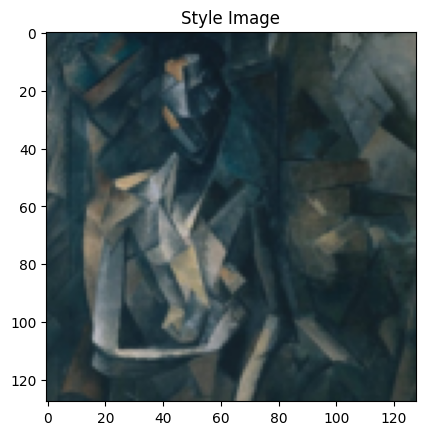

<PIL.Image.Image image mode=RGB size=128x128 at 0x7D6DFF6E38E0>


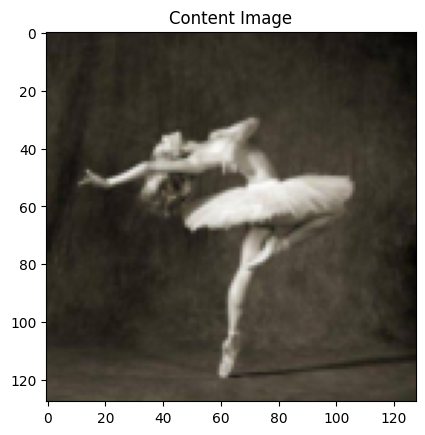

In [ ]:
unloader = transforms.ToPILImage()
plt.ion() #이미지를 갱신한다.

## 실습 : PIL을 활용하면, openCV 때처럼 permutation을 수행할 필요가 없다
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # Tensor의 값에 변화가 적용되지 않도록 Tensor를 복제한다.
    image = image.squeeze(0)      # 임의로 삽입한 batch dimension을 제거한다.

    #### 이미지 변환
    image = unloader(image)       # Tensor를 PIL image로 변환한다.b
    print(image)
    plt.imshow(image)             # Image를 visualize한다.
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 이미지의 visualize 결과가 나타날 수 있도록 잠시 정지한다.


plt.figure()
imshow(style_img, title='Style Image') # Style image를 visualize한다.

plt.figure()
imshow(content_img, title='Content Image')  # Content image를 visualize한다.

Neural style transfer에서는 이미지의 특성을 학습한 CNN 모델을 이용해 이미지의 content distance와 style distance를 획득한다.
  - 일반적으로 이미지의 분류를 위해 사전학습된 CNN 모델이 활용된다.
  - 이번 실험에서는 ImageNet에서 사전학습된 VGG19 신경망을 이용한다.

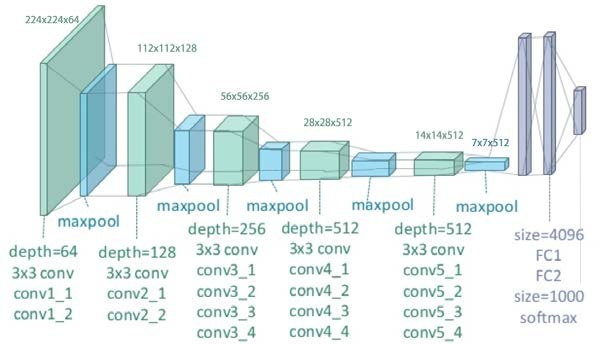 [[그림 출처]](https://www.researchgate.net/figure/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_fig2_325137356)

 - VGG19 신경망은 위의 그림과 같이 2D convolution layer, MaxPooling layer, fully connected layer로 이루어져 있다.
  - 이 가운데 fully connected layer는 분류를 위한 부분으로 분류되어, 이번 실험에서는 사용하지 않는다.
  - Neural style transfer에는 이미지로부터 특징(feature)를 추출하는 특징 추출기 (feature extractor)가 활용된다.

In [ ]:
import torchvision.models as models

####### 실습 : Pretrained VGG를 로드한다.

#사전 학습된 VGG19 모델의 feature extractor를 device로 보내고, 평가 모드로 세팅한다.
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:14<00:00, 40.5MB/s]


- 실험에 사용할 VGG19 신경망은 mean=[0.485, 0.456, 0.406]와 std=[0.229, 0.224, 0.225]를 이용해 normalize된 이미지를 이용해 학습하였으므로, 동일한 mean과 std를 이용해 normalize를 수행한다.

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

### 실습 : Channel 별로 입력 이미지를 정규화하는 모듈을 만든다
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1) # view (텐서의 모양을 바꾸는 함수)를 이용해 mean과 std tensor의 형태를 바꾸어 normalize 과정에서 바로 이용할 수 있도록 한다.
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # img의 값을 정규화(normalize)한다.
        return (img - self.mean) / self.std

### 3.2 Content loss 및 Style loss 정의하기
- Style Transfer는 content distance $D_C(X,C)$와 style distance $D_S(X,S)$를 동시에 최소화하는 것을 통해 이루어진다.
- 이를 위해 우선 content distance $D_C(X,C)$를 정의한다.
$$D_{C}^{L}(X, C)=\left\|F_{X L}-F_{C L}\right\|^{2}=\sum_{i}\left(F_{X L}(i)-F_{C L}(i)\right)^{2}$$
  - $F_{X L}$은 input image $X$가 CNN을 통과하는 과정에서 깊이 레벨 L에서 얻어지는 특징 맵 (feature map)을 의미한다.  
  - 마찬가지로, $F_{C L}$은 content image $C$이 CNN을 통과하는 과정에서 깊이 레벨 L에서 얻어지는 특징 맵 (feature map)을 의미한다.  
  - 아래 그림과 같이 입력 이미지가 CNN을 통과하는 과정에서 각각의 layer들로부터 서로 다른 특징 맵들을 획득할 수 있다.

  - $F_{XL}$는 단일 벡터 형태로 나타나며, $F_{XL}(i)$는 $F_{XL}$의 $i$번째 요소를 뜻한다.
  - Input image $X$와 content image $C$ 사이의 거리는 $X$가 입력일 때의 특징 맵 $F_{XL}$과 $C$가 입력일 때의 특징 맵 $F_{CL}$사이의 평균 제곱 오차(MSE, Mean Square Error)로 계산된다.

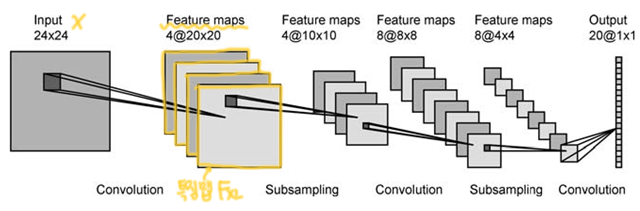 [[그림 출처]](https://intellipaat.com/community/2810/convolutional-neural-network-how-to-get-the-feature-maps)






- 위와 같은 $D_{C}^{L}(X, C)$를 content loss로 정의하고, 이를 계산하기 위한 추가 모듈인 ContentLoss layer를 신경망에 추가한다.
  - ContentLoss layer는 신경망에서 input image $X$를 받았을 때, 레이어 $L$에서 특징 맵 $F_{XL}$을 가져와서 input image $X$와 content image $C$ 사이의 weighted content distance $w_{CL} \cdot D^L_C(X,C)$를 반환한다.
  - Input image $X$가 입력되었을 때 이미 content image의 특징 맵 $F_{CL}$이 계산되어 있어야 하므로, ContentLoss layer의 생성 과정에서 $F_{CL}$를 입력으로 받아 detach 메소드를 사용해 gradient 계산에 사용되지 않도록 한다.
  - ContentLoss layer의 forward 메소드를 통해 content loss를 계산하고, 신경망의 연산 과정에 ContentLoss layer가 영향을 미치지 않도록 layer의 input을 그대로 반환한다. 이 과정을 거치면 autograd를 통해 content loss의 gradient 계산을 수행할 수 있다.


In [ ]:
## 실습 : 2장 이미지의 Pixel간 거리를 계산할 때에도 MSE를 활용할 수 있다
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 그라디언트를 동적으로 계산하는 데 사용되는 트리에서 대상 콘텐츠를 분리. 이 값은 변수(variable)가 아니라 명시된 값(stated value)이다.
        self.target = target.detach() #레이어를 생성할 때 content image를 입력으로 받아서 F_CL를 미리 계산해놓는다. self.target이 F_CL이다.

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        #input이 F_XL이고, self.target이 F_CL이다.
        #input image X가 들어오면 F_XL과 F_CL 사이의 MSE를 계산해서 self.loss에 넣는다.
        #self.loss가 content loss(=content 거리)이다.
        return input #Contentloss는 투명 레이어이므로, 입력을 다시 반환한다.

- 다음으로, style distance  $D_S(X,S)$을 정의한다.
$$G_{X L}(k, l)=\left\langle F_{X L}^{k}, F_{X L}^{l}\right\rangle=\sum_{i} F_{X L}^{k}(i) \cdot F_{X L}^{l}(i)$$
$$D_{S}^{L}(X, S)=\left\|G_{X L}-G_{S L}\right\|^{2}=\sum_{k, l}\left(G_{X L}(k, l)-G_{S L}(k, l)\right)^{2}$$
- Gram matrix $G_{X L}(k, l)$은 input image $X$가 신경망을 통과할 때 깊이 레벨 $L$에서 $k$번째 특징 맵과 $l$번째 특징 맵 사이의 상관 관계를 의미한다.
- Input image $X$와 style image $S$ 사이의 style distance $D_S(X,S)$는 이 상관관계 행렬 사이의 평균 제곱 오차(MSE, Mean Square Error)로 나타낼 수 있다.

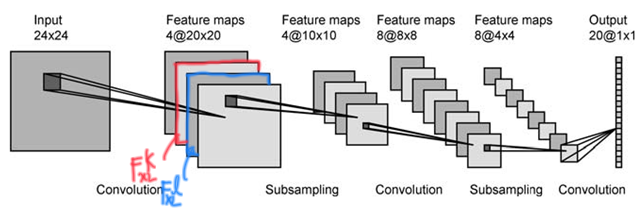

- Gram matrix $G_{X L}(k, l)$는 특징 맵($F_{X L}$)과 그 특징맵을 transpose 한 행렬을 곱하는 것으로 획득할 수 있다.
  - 계산을 위해서 [a,b,c,d] size의 4차원 텐서인 feature map을 [a * b, c * d] size의 2차원 matrix로 바꾸어, feature map의 한 channel을 하나의 row로 벡터화한다.
  - 마지막으로, 각 layer 별 feature의 개수의 차이를 보정하기 위해 전체 feature의 개수인 (a * b * c * d) 값으로 계산된 행렬을 나누어 normalization한다. 이를 통해 feature의 수가 많은 첫번째 layer가 gradient descent 과정에서 너무 큰 영향을 미치는 것을 방지할 수 있다.

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a는 batch size (=1), b는 feature map들의 갯수(channel의 수) 이다 (위 그림에서 b=4).
    # (c,d) 는 feature map의 높이와 넓이이다. (위 그림에서 c = d = 20)

    features = input.view(a * b, c * d)  # feature map의 각 channel을 row로 벡터화시킨다.

    G = torch.mm(features, features.t())  # feature map들 사이의 상관관계 행렬을 구한다.

    return G.div(a * b * c * d)  # 계산된 matrix G를 전체 feature의 개수로 나누어 normalize 한다.

- Content loss와 마찬가지로 $D_S(X,S)$를 style loss로 정의하고, 이를 계산하기 위한 추가 모듈인 StyleLoss layer를 신경망에 추가한다.
  - StyleLoss layer의 생성 과정에서는 style image의 gram matrix $G_{SL}$을 입력으로 받는다.
  - Style matrix의 forward 메소드를 통해 gram matrix 사이의 MSE loss로 style loss를 계산하고, ContentLoss layer와 마찬가지로 layer의 input을 그대로 반환한다.

In [ ]:

### 실습 : 위에서 정의한 gram matrix를 이용하여 style loss를 완성하세요
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach() #style image의 gram matrix를 계산한다.

    def forward(self, input):
        ####실습:
        G = gram_matrix(input) #input image의 gram matrix를 계산한다.
        self.loss = F.mse_loss(G, self.target) #style loss(=style 거리)를 구한다.
        return input

- 정의한 ContentLoss layer와 Styleloss layer를 VGG 모델의 각 convolution layer의 바로 다음에 추가하여 이용한다.
  - Content loss는 4번째 convolution layer에서만 계산한다.
  - Style loss는 모든 convolution layer에 대해 계산한다.

In [ ]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2'] #, 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    #vgg19를 복사한다.
    cnn = copy.deepcopy(cnn)

    # 표준화(normalization) 모듈
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # loss값을 저장하기 위한 list를 선언한다.
    content_losses = []
    style_losses = []

    ## 실습 : 앞서 정의한 normalization을 맨 처음 동작하게 합니다
    # nn.Sequential을 이용해 순차적으로 신경망 layer와 loss layer를 모델에 추가한다.
    model = nn.Sequential(normalization)

    ### 실습 : 기존 Pretrained된 모델에서 필요한 부분만 뽑아 쓰는 부분
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d): #Conv2d layer
            i += 1 # conv레이어를 찾을때마다 값을 증가
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU): #ReLU layer
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d): #MaxPool2d layer
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d): #BatchNorm2d layer
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer) #레이어를 추가함.


        ## 실습 : 특정 layer에 추가적인 기능을 연결하는 부분
        #layer가 content_layers 중에 하나라면 ContentLoss layer를 추가한다:
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target) #content_img를 지금까지 만든 model에 넣어서 conteng image의 feature map을 계산한다.
            model.add_module("content_loss_{}".format(i), content_loss) #ContentLoss layer를 추가한다.
            content_losses.append(content_loss)

        ## 실습 : 특정 layer에 추가적인 기능을 연결하는 부분
        #layer가 style_layers 중에 하나라면 StyleLoss layer를 추가한다:
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature) #style_img를 지금까지 만든 model에 넣어서 style image의 gram matrix를 계산한다.
            model.add_module("style_loss_{}".format(i), style_loss) #StyleLoss layer를 추가한다.
            style_losses.append(style_loss)

    # 마지막 ContentLoss 또는 StyleLoss 이후의 layer들을 제거한다.
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

### 3.3 Gradient Descent를 이용한 Style Transfer

<PIL.Image.Image image mode=RGB size=128x128 at 0x7D6DFD6101F0>


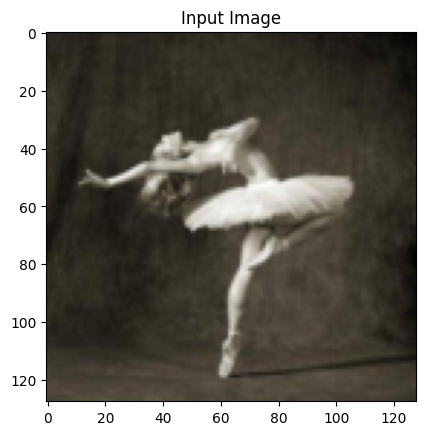

In [ ]:
#content 이미지를 복사해서 입력 이미지로 사용한다.
input_img = content_img.clone()

# 원본 입력 이미지를 출력.
plt.figure()
imshow(input_img, title='Input Image')

- L-BFGS 알고리즘을 이용해 gradient descent를 수행한다.
  - 기존의 신경망 학습 예제와는 달리, input image를 업데이트 해야 하므로 `input_img`를 optimizer의 파라미터로 입력하여 gradient descent를 수행한다.

In [ ]:
def get_input_optimizer(input_img):
    #input image 자체를 업데이트가 필요한 파라미터로 입력한다.
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

- Style transfer를 수행할 함수 `run_style_transfer`를 다음과 같이 정의한다.
  - 매 loop에서 loss를 계산하여 input image를 업데이트한다.
  - 업데이트한 input image를 다음 루프에서 다시 입력으로 이용한다.
  - L-BFGS 알고리즘을 이용해 파라미터를 업데이트 하는 과정에서 함수를 여러번 다시 계산할 수 있도록 `closure`라는 함수를 정의하여 이용한다.
    - `closure`함수는 gradient를 0으로 만들고, 해당 지점에서 loss를 계산하여 반환한다.
    - 정의된 `closure` 함수는 `optimizer.step(closure)`와 같이 파라미터 업데이트 코드의 argument로 사용된다.

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1, content_layers=['conv_4'], style_layers= ['conv_1', 'conv_2']):


    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, content_layers,style_layers )   #get_style_model_and_losses를 이용해 model, style_losses, content_losses를 구한다.
    optimizer = get_input_optimizer(input_img)     #get_input_optimizer를 이용해 input image를 업데이트 시키는 optimizer를 정의한다.


    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 업데이트된 input image의 픽셀 값들을 0과 1 사이로 보정한다.
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            #각 layer에서 획득한 loss들을 합산한다.
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            #style_score와 content_score의 비중을 비슷하게 하기 위해 입력받은 가중치를 곱해서 합산한다.
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score #style loss와 content loss를 더한 값을 최종 loss로 사용한다.

        optimizer.step(closure)

    # 마지막으로 업데이트된 input image의 픽셀 값들을 0과 1 사이로 보정한다.
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


<ipython-input-8-fec7155eb88b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1) # view (텐서의 모양을 바꾸는 함수)를 이용해 mean과 std tensor의 형태를 바꾸어 normalize 과정에서 바로 이용할 수 있도록 한다.
<ipython-input-8-fec7155eb88b>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 0.361139 Content Loss: 1.791977

run [100]:
Style Loss : 0.290085 Content Loss: 1.645139

run [150]:
Style Loss : 0.287293 Content Loss: 1.595215

run [200]:
Style Loss : 0.286559 Content Loss: 1.569680

run [250]:
Style Loss : 129713.210938 Content Loss: 327.598114

run [300]:
Style Loss : 76.906563 Content Loss: 17.925592

<PIL.Image.Image image mode=RGB size=128x128 at 0x7D6DFD696A70>


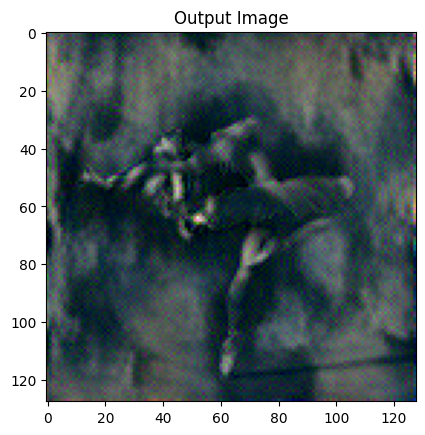

In [ ]:
# 실습 : Convolution Layer 2 전까지의 Style 만을 이용한 결과 확인
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2']
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, content_layers=content_layers_default, style_layers=style_layers_default)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..


<ipython-input-8-fec7155eb88b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1) # view (텐서의 모양을 바꾸는 함수)를 이용해 mean과 std tensor의 형태를 바꾸어 normalize 과정에서 바로 이용할 수 있도록 한다.
<ipython-input-8-fec7155eb88b>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 8.751247 Content Loss: 11.501593

run [100]:
Style Loss : 4.642909 Content Loss: 10.868773

run [150]:
Style Loss : 3.379435 Content Loss: 10.098667

run [200]:
Style Loss : 2.700446 Content Loss: 9.427785

run [250]:
Style Loss : 2.292618 Content Loss: 8.919922

run [300]:
Style Loss : 1.997301 Content Loss: 8.504628

<PIL.Image.Image image mode=RGB size=128x128 at 0x7D6DFD66B760>


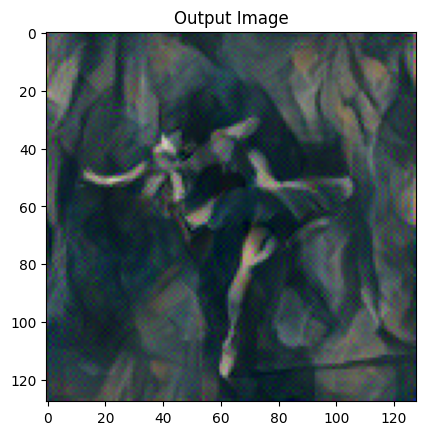

In [ ]:
# 실습 : Convolution Layer 5 전까지의 Style 만을 이용한 결과 확인
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, content_layers=content_layers_default,
                            style_layers=style_layers_default)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()